# Module 3 Project - Introduction

Business Case - A bank would like to improve their ability to predict credit card defaults.  In order to do this they would like to see a model that is able to make more accurate predictions than the base model.  There are a few specific questions that would be helpful to answer along the way.  
- What is the baseline accuracy level?
- Is there enough information in this data to make predictions?  Any obstacles?
- What factors are strong predictors of default?


In [60]:
#importing all of the necessary modules (CHECK and remove unused before finishing)
import numpy as np 
import pandas as pd 
from scipy.stats import entropy
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from imblearn.over_sampling import SMOTE
from math import log
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

# Initial Data Exploration
The first step  will be to import and examine the basics of the dataset so that we can  begin cleaning it.  I will check to make sure variables are the correct data type, make sure there are no anomalies, etc.  I'll also be keeping an eye out for any potential patterns and start thinking about what would make a strong model for the specific data. 

In [2]:
#Importing the data and taking a first look at it.  
df = pd.read_csv('UCI_Credit_Card.csv').drop('ID', axis=1)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
#Examining some basic information about the data set.  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [4]:
#Separating the data into categorical and continuous variables.
cats = []
conts = []
for col in df.columns:
    if df[col].nunique() <= 75:
        cats.append(col)
    else:
        conts.append(col)
df_cats = df.loc[:,cats]
df_conts = df.loc[:,conts]
print(cats)
print(conts)

['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default.payment.next.month']
['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


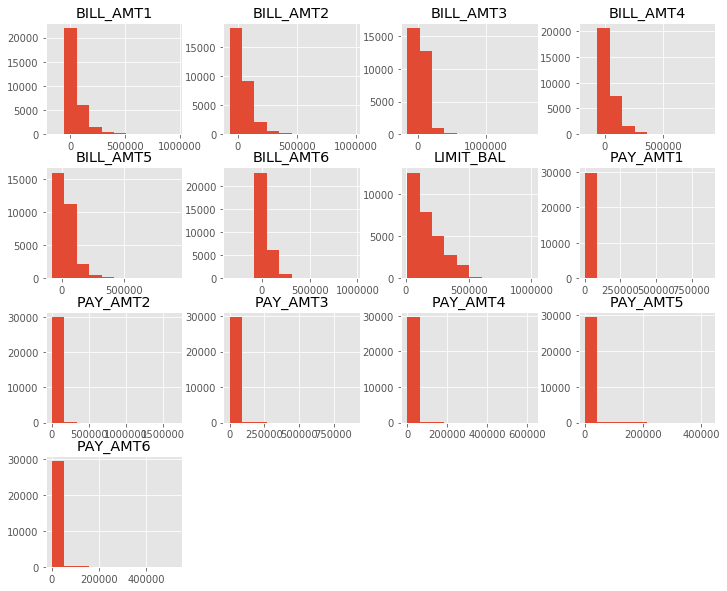

In [5]:
# Looking at the continuous variables in a bit more detail
df_conts.hist(figsize=(12,10))
df_conts.describe()

# Continue Exploration with Data Cleaning
Now that I've gotten a very basic look at the data, there are some issues that will need to be addressed through data  cleaning.  This can be done as we continue to explore the data.  For example, there are a few variables stored as ones and twos when it would make more sense (at least for my purposes) to store them as zero and one.  I will also be splitting the data for the first time to take a very early look at our features using Ridge and Lasso regressions.  

In [6]:
# Creating function to drop outliers
# Creating a function to split data more easily
# Creating a function to transform the data
def drop_outliers(df, z_score=3):
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_score, result_type='reduce') \
        .all(axis=1)
    df.drop(df.index[~constrains], inplace=True)
    
def my_split(features, target):
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25)
    
def my_transform(X_train, X_test, binary=True):
    global X_train_transformed
    global X_test_transformed
    X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train), \
                                       columns=X_train.columns, index=X_train.index)
    X_test_transformed = pd.DataFrame(scaler.transform(X_test), \
                                      columns=X_train.columns, index=X_test.index)
    if binary == True:
        X_train_transformed[binary_features] = X_train[binary_features]
        X_test_transformed[binary_features] = X_test[binary_features]

In [7]:
# Dropping outliers from the continuous variables
new_df_conts = df_conts
drop_outliers(new_df_conts)

In [8]:
# Joining the remaining continuous data with the rest so that the indexes match
# Splitting data into training and test sets
#Created a function to make splitting data faster
test_df = new_df_conts.merge(df_cats, left_index=True, right_index=True).reset_index(drop=True)
target = test_df['default.payment.next.month']
features = test_df.drop(['default.payment.next.month'], axis=1)

my_split(features,target)

In [9]:
# Setting up MinMaxScaler and transforming the data.

scaler = MinMaxScaler()
my_transform(X_train, X_test, binary=False)

In [10]:
# Initializing Ridge, Lasso, and Linear Regression

ridge = Ridge(alpha=0.001)
ridge.fit(X_train_transformed, y_train)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_transformed, y_train)

lin = LinearRegression()
lin.fit(X_train_transformed, y_train)

train_len = len(X_train_transformed)
test_len = len(X_test_transformed)

In [11]:
# Generate predictions for training and test sets
y_h_ridge_train = ridge.predict(X_train_transformed)
y_h_ridge_test = ridge.predict(X_test_transformed)

y_h_lasso_train = np.reshape(lasso.predict(X_train_transformed), (train_len,))
y_h_lasso_test = np.reshape(lasso.predict(X_test_transformed), (test_len,))

y_h_lin_train = lin.predict(X_train_transformed)
y_h_lin_test = lin.predict(X_test_transformed)

In [12]:
# Printing a read-out displaying the relevant error information.

print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train)**2))
print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test)**2))
print('\n')

print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train)**2))
print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test)**2))
print('\n')

print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train_transformed))**2))
print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test_transformed))**2))

Train Error Ridge Model 3109.2173924801286
Test Error Ridge Model 1053.6159719802597


Train Error Lasso Model 3124.350023824495
Test Error Lasso Model 1056.0368804641553


Train Error Unpenalized Linear Model 3109.2173924577746
Test Error Unpenalized Linear Model 1053.6161096208266


In [13]:
# Examining the coefficients (especially Lasso as it can be used for feature elimination)
# Here we also see the answer to one of our original questions
# A few of the Lasso coefficients are much larger than average
# This is a good indication that these are strong predictors

print('Ridge parameter coefficients:', ridge.coef_)
print('Lasso parameter coefficients:', lasso.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [-0.02628787 -0.30215217 -0.11244673  0.14367561  0.02749053 -0.21434135
  0.26850965 -0.06645098 -0.17287523 -0.10006972 -0.02605451 -0.15004638
 -0.04005881 -0.01284224 -0.10921082 -0.07722793  0.06666847  0.91606123
  0.25092116  0.0662691   0.10779845  0.03270679  0.0171107 ]
Lasso parameter coefficients: [-0.02992497 -0.20662107 -0.         -0.         -0.         -0.
  0.         -0.05391711 -0.07190618 -0.061687   -0.00738643 -0.06837494
 -0.00325449 -0.01096938 -0.0180357  -0.04701335  0.02664117  0.8943802
  0.22268514  0.06604789  0.09825724  0.00714278  0.00457117]
Linear model parameter coefficients: [-0.02628742 -0.30215609 -0.11245077  0.14368681  0.02749451 -0.21437264
  0.26853351 -0.06644986 -0.17287802 -0.1000692  -0.02605082 -0.15005088
 -0.04005793 -0.01284225 -0.10921125 -0.077228    0.06666858  0.91606685
  0.25092095  0.06626746  0.10779827  0.03270685  0.01710954]


In [14]:
# Initial Lasso suggests that all 'BILL' columns except the first one can be dropped
# Returning to the original dataframe since I want to add new columns
# And outliers will need to be dropped again
# Doing this prevents dropping outliers from the same data twice
# Also making a for loop to make new columns showing percent of bill paid monthly
for x in range(0,5):
    df['PRCT_{val}'.format(val=x+1)] = df['PAY_AMT{val}'.format(val=x+1)] \
    / df['BILL_AMT{val}'.format(val=x+2)]
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,PRCT_1,PRCT_2,PRCT_3,PRCT_4,PRCT_5
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,1,0.000000,1.000000,NaN,NaN,NaN
1,120000.0,2,2,2,26,-1,2,0,0,0,...,1000.0,1000.0,0.0,2000.0,1,0.000000,0.372856,0.305623,0.289436,0.000000
2,90000.0,2,2,2,34,0,0,0,0,0,...,1000.0,1000.0,1000.0,5000.0,0,0.108220,0.110628,0.069779,0.066899,0.064313
3,50000.0,2,2,1,37,0,0,0,0,0,...,1200.0,1100.0,1069.0,1000.0,0,0.041465,0.040961,0.042382,0.037985,0.036180
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,10000.0,9000.0,689.0,679.0,0,0.352734,1.023608,0.477555,0.470072,0.036015


In [15]:
# Changed the 'SEX' variable to a dummy variable representing 'female' so it would be less confusing
# Created a dummy variable signifying 'married'
df['FEMALE'] = df['SEX'] - 1
df['MARRIED'] = 0
for x in range(0, len(df)):
    if df.loc[x, 'MARRIAGE'] == 1:
        df.loc[x, 'MARRIED'] = 1

In [16]:
# Dropped unknown education levels 
unknown_edu = pd.concat([df[df['EDUCATION'] > 3], \
                        df[df['EDUCATION'] == 0]])

unknown_list = unknown_edu.index.tolist()
df = df.drop(index = unknown_list).reset_index(drop=True)
unknown_edu['EDUCATION'].value_counts()

5    280
4    123
6     51
0     14
Name: EDUCATION, dtype: int64

In [17]:
# Creating dummy variables for Grad School and University
# Leaving out high school to prevent perfect multicollinearity.  
df['GRADSCHOOL'] = 0
df['UNIVERSITY'] = 0
for x in range(0, len(df)):
    if df.loc[x, 'EDUCATION'] == 1:
        df.loc[x, 'GRADSCHOOL'] = 1
    elif df.loc[x, 'EDUCATION'] == 2:
        df.loc[x, 'UNIVERSITY'] = 1

In [18]:
# Creating a drop list - will be dropping 'BILL' columns as previously mentioned
# Also dropping columns replaced by dummy variables
drop_list = ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', \
            'EDUCATION', 'MARRIAGE', 'SEX']


In [20]:
# Dropping the unnecessary columns and replacing the infinity and NaN values with 0
# Since these were all created when the PAY_AMT was divided
data = df.replace([np.inf, -np.inf], np.nan)
data = data.drop(drop_list, axis=1).fillna(0)
data.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,PAY_AMT1,...,default.payment.next.month,PRCT_1,PRCT_2,PRCT_3,PRCT_4,PRCT_5,FEMALE,MARRIED,GRADSCHOOL,UNIVERSITY
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,0.0,...,1,0.000000,1.000000,0.000000,0.000000,0.000000,1,1,0,1
1,120000.0,26,-1,2,0,0,0,2,2682.0,0.0,...,1,0.000000,0.372856,0.305623,0.289436,0.000000,1,0,0,1
2,90000.0,34,0,0,0,0,0,0,29239.0,1518.0,...,0,0.108220,0.110628,0.069779,0.066899,0.064313,1,0,0,1
3,50000.0,37,0,0,0,0,0,0,46990.0,2000.0,...,0,0.041465,0.040961,0.042382,0.037985,0.036180,1,1,0,1
4,50000.0,57,-1,0,-1,0,0,0,8617.0,2000.0,...,0,0.352734,1.023608,0.477555,0.470072,0.036015,0,1,0,1


In [21]:
# Separating the data into categorical and continuous variables once again.
cats = []
conts = []
for col in data.columns:
    if data[col].nunique() <= 75:
        cats.append(col)
    else:
        conts.append(col)
df_cats = data.loc[:,cats]
df_conts = data.loc[:,conts]
print('CAT:', cats)
print('CONT:', conts)

CAT: ['AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default.payment.next.month', 'FEMALE', 'MARRIED', 'GRADSCHOOL', 'UNIVERSITY']
CONT: ['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'PRCT_1', 'PRCT_2', 'PRCT_3', 'PRCT_4', 'PRCT_5']


In [22]:
# Dropping outliers once again
new_df_conts = df_conts
drop_outliers(new_df_conts)

In [23]:
# Basic data cleaning is over, creating the dataset that will be used going forward
data = new_df_conts.merge(df_cats, left_index=True, right_index=True).reset_index(drop=True)
data.head()

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PRCT_1,PRCT_2,...,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month,FEMALE,MARRIED,GRADSCHOOL,UNIVERSITY
0,20000.0,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,2,-1,-1,-2,-2,1,1,1,0,1
1,120000.0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0.000000,0.372856,...,2,0,0,0,2,1,1,0,0,1
2,90000.0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.108220,0.110628,...,0,0,0,0,0,0,1,0,0,1
3,50000.0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.041465,0.040961,...,0,0,0,0,0,0,1,1,0,1
4,50000.0,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.352734,1.023608,...,0,-1,0,0,0,0,0,1,0,1


# Further Data Exploration and Feature Selection
Here we will explore the data in a bit more detail, using Lasso regression to select more features, and even creating a simple model to help determine if we are overfitting our data.  We will also take a look at class imbalance and attempt to address it.

In [24]:
# Splitting cleaned data into training and test sets so that 
# Features can be eliminated using Lasso regression
target = data['default.payment.next.month']
features = data.drop('default.payment.next.month', axis=1)
my_split(features,target)

In [25]:
# Scaling data with minmaxscaler, but leaving binary data unchanged
# Binary data already has the proper range 
binary_features = ['FEMALE', 'MARRIED', 'GRADSCHOOL', 'UNIVERSITY']
my_transform(X_train, X_test, binary=True)

In [26]:
# Taking a look at the value counts for the target to see if oversampling could be helpful
print('Raw counts: \n')
print(data['default.payment.next.month'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(data['default.payment.next.month'].value_counts(normalize=True))

Raw counts: 

0    20757
1     6252
Name: default.payment.next.month, dtype: int64
-----------------------------------
Normalized counts: 

0    0.768522
1    0.231478
Name: default.payment.next.month, dtype: float64


In [27]:
# There is an imbalance, so I'm using SMOTE
# To correct for this using synthetic class distribution
smote = SMOTE(random_state=25)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_transformed, y_train) 
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


-----------------------------------------
Synthetic sample class distribution: 

1    15555
0    15555
dtype: int64


In [28]:
# Setting grid parameters for a model to check on overfitting
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [5],
    'subsample': [ 0.7],
    'n_estimators': [300],
}

In [29]:
# Since the class imbalance has been addressed, now would be a good time to check for overfitting
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resampled)
val_preds = grid_clf.predict(X_test_transformed.values)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 5
n_estimators: 300
subsample: 0.7

Training Accuracy: 90.92%
Validation accuracy: 80.39%


In [30]:
# Training accuracy was far higher than validation, so overfitting seems likely.
# Checking the AUC and confusion matrix
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, val_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, val_preds, rownames=['True'], colnames=['Predicted'], margins=True)


AUC is :0.67

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,4789,413,5202
1,911,640,1551
All,5700,1053,6753


In [31]:
# There is likely overfitting, so it is time for more feature selection
# Created a function that uses Lasso to easily help with this task
# It returns a list of all the zero coefficents produced by a Lasso regression
def my_lasso(X_train, X_test, y_train, y_test, a):
    global zero_list
    zero_list = []
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    train_len = len(X_train)
    test_len = len(X_test)
    y_h_lasso_train = np.reshape(lasso.predict(X_train), (train_len,))
    y_h_lasso_test = np.reshape(lasso.predict(X_test), (test_len,))
    print('Lasso parameter coefficients:', lasso.coef_)
    for x in range(1, len(lasso.coef_)):
        if lasso.coef_[x] == 0:
            zero_list.append(X_train.columns[x])
    print('---------------------------------------------')
    print('Columns with coefficient of zero:', zero_list)

In [32]:
# Using Lasso function to get a list of features I can potentially drop
my_lasso(X_train_transformed, X_test_transformed, y_train, y_test, a=.0015)

Lasso parameter coefficients: [-2.46286597e-02 -1.91909268e-01 -6.15771887e-02 -4.68430493e-02
 -1.12101790e-02 -0.00000000e+00 -2.95035181e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  8.94121183e-01  2.19334819e-01
  5.52060982e-02  6.91902102e-02  0.00000000e+00  0.00000000e+00
 -1.83515109e-02  3.23728883e-02  2.14188228e-04 -0.00000000e+00]
---------------------------------------------
Columns with coefficient of zero: ['PAY_AMT4', 'PAY_AMT6', 'PRCT_1', 'PRCT_2', 'PRCT_3', 'PRCT_4', 'PRCT_5', 'AGE', 'PAY_5', 'PAY_6', 'UNIVERSITY']


In [33]:
# Dropping the zero columns from the dataset
data = data.drop(zero_list, axis=1)
data.head()

,LIMIT_BAL,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT5,PAY_0,PAY_2,PAY_3,PAY_4,default.payment.next.month,FEMALE,MARRIED,GRADSCHOOL
0,20000.0,3913.0,0.0,689.0,0.0,0.0,2,2,-1,-1,1,1,1,0
1,120000.0,2682.0,0.0,1000.0,1000.0,0.0,-1,2,0,0,1,1,0,0
2,90000.0,29239.0,1518.0,1500.0,1000.0,1000.0,0,0,0,0,0,1,0,0
3,50000.0,46990.0,2000.0,2019.0,1200.0,1069.0,0,0,0,0,0,1,1,0
4,50000.0,8617.0,2000.0,36681.0,10000.0,689.0,-1,0,-1,0,0,0,1,0


In [34]:
# Resampling the data to check the model again for overfitting
target = data['default.payment.next.month']
features = data.drop('default.payment.next.month', axis=1)
binary_features.remove('UNIVERSITY')
my_split(features,target)
my_transform(X_train, X_test, binary=True)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_transformed, y_train) 

/Users/derekvanbriesen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [35]:
# Checking for any obvious overfitting
#It seems better now, we can move on to graphing
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_transformed, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_transformed)
val_preds = grid_clf.predict(X_test_transformed)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 5
n_estimators: 300
subsample: 0.7

Training Accuracy: 85.43%
Validation accuracy: 81.19%


# Graphs
Now that we have properly addressed our data, we can begin using modeling to predict defaults.  The way I plan on doing this is by iterating through different hyperparameter values for a couple of specific estimators.  I can then find the parameter values associated with the higher test accuracy, and tune my model with these values.  I will be graphing each parameter value against the accuracy of the resulting classifier so that I can observe any trends caused by increases or decreases in these values.  The specific models used here (XGBoost and  RandomForest) are the ones that were most successful when I ran my data through several basic models.  

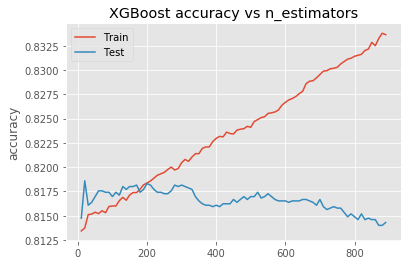

<Figure size 432x288 with 0 Axes>

In [36]:
# Iterating through xgb predictions for different n_estimators values
tree_list = np.arange(10, 900, 10) 
train = []
test = []

for tree in tree_list:
    clf = xgb.XGBClassifier(n_estimators=tree, n_jobs = -1, random_state=25)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    trainpred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, trainpred)
    test_acc = accuracy_score(y_test, prediction)
    train.append(train_acc)
    test.append(test_acc)
    
acc_vs_est = pd.DataFrame({'n_estimators':tree_list,'Train_acc':train,'Test_acc':test})

fig, ax = plt.subplots()
x_axis = tree_list
ax.plot(x_axis, acc_vs_est['Train_acc'], label='Train')
ax.plot(x_axis, acc_vs_est['Test_acc'], label='Test')
ax.legend()
plt.ylabel('accuracy')
plt.title('XGBoost accuracy vs n_estimators')
plt.show()
plt.savefig('acc_vs_est.png', dpi = 300)

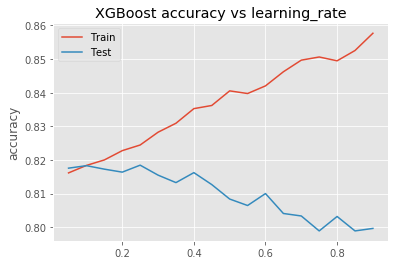

<Figure size 432x288 with 0 Axes>

In [37]:
# Iterating through xgb predictions for different learning_rate values
rate_list = np.arange(0.05, 0.95, 0.05) 
train = []
test = []

for tree in rate_list:
    clf = xgb.XGBClassifier(n_estimators=200, learning_rate=tree, n_jobs = -1, random_state=25)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    trainpred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, trainpred)
    test_acc = accuracy_score(y_test, prediction)
    train.append(train_acc)
    test.append(test_acc)
    
acc_vs_rate = pd.DataFrame({'learning_rate':rate_list,'Train_acc':train,'Test_acc':test})

fig, ax = plt.subplots()
x_axis = rate_list
ax.plot(x_axis, acc_vs_rate['Train_acc'], label='Train')
ax.plot(x_axis, acc_vs_rate['Test_acc'], label='Test')
ax.legend()
plt.ylabel('accuracy')
plt.title('XGBoost accuracy vs learning_rate')
plt.show()
plt.savefig('acc_vs_rate.png', dpi = 300)

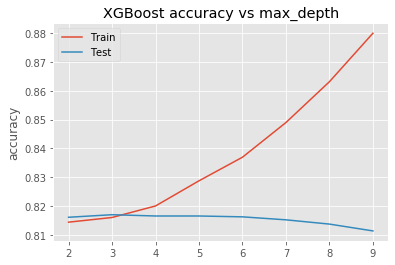

<Figure size 432x288 with 0 Axes>

In [38]:
# Iterating through xgb predictions for different max_depth values
tree_list = np.arange(2, 10) 
train = []
test = []

for tree in tree_list:
    clf = xgb.XGBClassifier(max_depth=tree, n_jobs = -1, random_state=25)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    trainpred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, trainpred)
    test_acc = accuracy_score(y_test, prediction)
    train.append(train_acc)
    test.append(test_acc)
    
acc_vs_depth = pd.DataFrame({'max_depth':tree_list,'Train_acc':train,'Test_acc':test})

fig, ax = plt.subplots()
x_axis = tree_list
ax.plot(x_axis, acc_vs_depth['Train_acc'], label='Train')
ax.plot(x_axis, acc_vs_depth['Test_acc'], label='Test')
ax.legend()
plt.ylabel('accuracy')
plt.title('XGBoost accuracy vs max_depth')
plt.show()
plt.savefig('acc_vs_depth.png', dpi = 300)

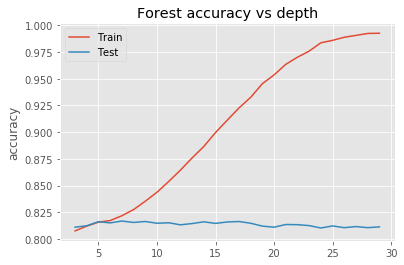

<Figure size 432x288 with 0 Axes>

In [39]:
# Iterating through rfc predictions for different max_depth values
depth_list = np.arange(3, 30)
train = []
test = []

for depth in depth_list:
    rfc = RandomForestClassifier(max_depth=depth, n_jobs = -1, random_state=42)
    rfc.fit(X_train, y_train)
    prediction = rfc.predict(X_test)
    trainpred = rfc.predict(X_train)
    train_acc = accuracy_score(y_train, trainpred)
    test_acc = accuracy_score(y_test, prediction)
    train.append(train_acc)
    test.append(test_acc)
    
forest_depth = pd.DataFrame({'n_estimators':depth_list,'Train_acc':train,'Test_acc':test})

fig, ax = plt.subplots()
x_axis = depth_list
ax.plot(x_axis, forest_depth['Train_acc'], label='Train')
ax.plot(x_axis, forest_depth['Test_acc'], label='Test')
ax.legend()
plt.ylabel('accuracy')
plt.title('Forest accuracy vs depth')
plt.show()
plt.savefig('forest_depth.png', dpi = 300)

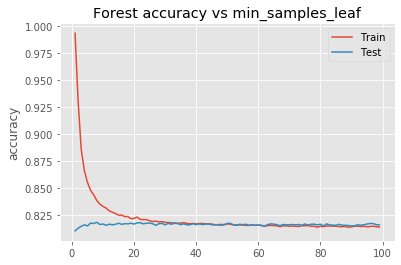

<Figure size 432x288 with 0 Axes>

In [40]:
# Iterating through rfc predictions for different min_samples_leaf values
leaf_list = np.arange(1, 100)
train = []
test = []

for leaf in leaf_list:
    rfc = RandomForestClassifier(min_samples_leaf=leaf, n_jobs = -1, random_state=42)
    rfc.fit(X_train, y_train)
    prediction = rfc.predict(X_test)
    trainpred = rfc.predict(X_train)
    train_acc = accuracy_score(y_train, trainpred)
    test_acc = accuracy_score(y_test, prediction)
    train.append(train_acc)
    test.append(test_acc)
    
forest_leaf = pd.DataFrame({'min_samples_leaf':leaf_list,'Train_acc':train,'Test_acc':test})

fig, ax = plt.subplots()
x_axis = leaf_list
ax.plot(x_axis, forest_leaf['Train_acc'], label='Train')
ax.plot(x_axis, forest_leaf['Test_acc'], label='Test')
ax.legend()
plt.ylabel('accuracy')
plt.title('Forest accuracy vs min_samples_leaf')
plt.show()
plt.savefig('forest_leaf.png', dpi = 300)

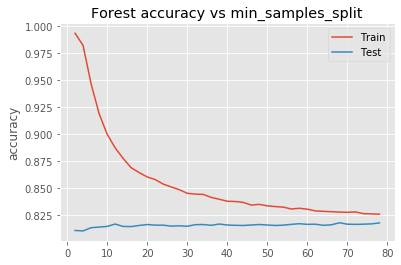

<Figure size 432x288 with 0 Axes>

In [41]:
# Iterating through rfc predictions for different min_samples_split values
split_list = np.arange(2, 80, 2)
train = []
test = []

for leaf in split_list:
    rfc = RandomForestClassifier(min_samples_split=leaf, n_jobs = -1, random_state=42)
    rfc.fit(X_train, y_train)
    prediction = rfc.predict(X_test)
    trainpred = rfc.predict(X_train)
    train_acc = accuracy_score(y_train, trainpred)
    test_acc = accuracy_score(y_test, prediction)
    train.append(train_acc)
    test.append(test_acc)
    
forest_split = pd.DataFrame({'min_samples_split':split_list,'Train_acc':train,'Test_acc':test})

fig, ax = plt.subplots()
x_axis = split_list
ax.plot(x_axis, forest_split['Train_acc'], label='Train')
ax.plot(x_axis, forest_split['Test_acc'], label='Test')
ax.legend()
plt.ylabel('accuracy')
plt.title('Forest accuracy vs min_samples_split')
plt.show()
plt.savefig('forest_split.png', dpi = 300)

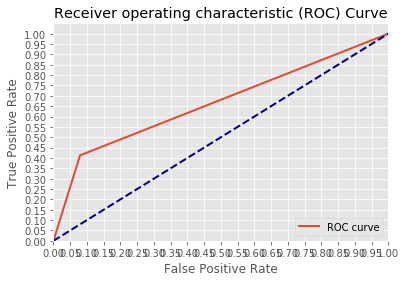

<Figure size 432x288 with 0 Axes>

In [42]:
# Plotting the ROC curve
fpr = false_positive_rate
tpr = true_positive_rate
lw = 2

plt.plot(fpr, tpr, lw=lw, label='ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
plt.savefig('ROC_curve.png', dpi = 300)

# Modeling 

In [43]:
# Calculating baseline model accuracy for the given data
baseline_acc = data['default.payment.next.month'].value_counts(normalize=True)[0]
print('Baseline accuracy level is:', baseline_acc)

Baseline accuracy level is: 0.7685216039098078


In [44]:
#Using the graphs to find parameters with maximum testing accuracy
acc_vs_est_max = acc_vs_est.sort_values(by='Test_acc', ascending=False).iloc[0,0]
acc_vs_rate_max = acc_vs_rate.sort_values(by='Test_acc', ascending=False).iloc[0,0]
acc_vs_depth_max = acc_vs_depth.sort_values(by='Test_acc', ascending=False).iloc[0,0]
print([acc_vs_est_max, acc_vs_rate_max, acc_vs_depth_max])

[20, 0.25, 3]


In [45]:
# Setting grid parameters according to graph values
param_grid = {
    "learning_rate": [acc_vs_rate_max],
    'max_depth': [acc_vs_depth_max],
    'n_estimators': [acc_vs_est_max]
}

In [46]:
# Testing out XGBoost with the resampled data.  Results were lackluster.
clf = xgb.XGBClassifier()
clf.fit(X_train_resampled, y_train_resampled)
training_preds = clf.predict(X_train_resampled)
val_preds = clf.predict(X_test_transformed.values)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 77.63%
Validation accuracy: 77.8%


In [47]:
# Running GridSearch with the parameters recommended by the graphs
#It is the most optimized result so far.
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.25
max_depth: 3
n_estimators: 20

Training Accuracy: 81.53%
Validation accuracy: 81.68%


In [48]:
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, val_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, val_preds, rownames=['True'], colnames=['Predicted'], margins=True)


AUC is :0.66

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,4926,276,5202
1,961,590,1551
All,5887,866,6753


In [49]:
# Checking to see if rfc is sensitive to the oversampled data
rfc = RandomForestClassifier(n_jobs = -1, random_state=42)
rfc.fit(X_train, y_train)
prediction = rfc.predict(X_test)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction) * 100,3)))

Accuracy: 81.075%


In [50]:
# It appears that it does perform worse, possibly because 
# Overfitting was a big problem with this data
rfc = RandomForestClassifier(n_jobs = -1, random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)
prediction = rfc.predict(X_test_transformed.values)
print("Accuracy: {}%".format(round(accuracy_score(y_test, prediction) * 100,3)))

Accuracy: 78.913%


In [51]:
#Using the graphs to find parameters with maximum testing accuracy
forest_depth_max = forest_depth.sort_values(by='Test_acc', ascending=False).iloc[0,0]
forest_leaf_max = forest_leaf.sort_values(by='Test_acc', ascending=False).iloc[0,0]
forest_split_max = forest_split.sort_values(by='Test_acc', ascending=False).iloc[0,0]
print([forest_depth_max, forest_leaf_max, forest_split_max])

[7, 8, 68]


In [52]:
rfc_grid = {'n_estimators': [100],
               'max_depth': [forest_depth_max],
               'min_samples_leaf': [forest_leaf_max],
               'min_samples_split' : [forest_split_max],
               'n_jobs' : [-1],
               'random_state' : [42]}

In [53]:
# Running RandomizedSeachCV with the parameters from the random forest graphs
# The result is extremely close to beating XGBoost but slightly below
grid_forest = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = rfc_grid, 
                               n_iter = 1, cv=5, random_state=42, n_jobs = -1, scoring = 'accuracy')


grid_forest.fit(X_train, y_train)

best_forest = grid_forest.best_estimator_
print(best_forest)
print("_"*40)
#with its score
print("Cross validated best score {}%".format(round(grid_forest.best_score_ * 100,3)))

predictions = best_forest.predict(X_test)
print("Test score: {}%".format(round(accuracy_score(y_true = y_test, y_pred = predictions) * 100,3)))

RandomForestClassifier(max_depth=7, min_samples_leaf=8, min_samples_split=68,
                       n_jobs=-1, random_state=42)
________________________________________
Cross validated best score 81.23%
Test score: 81.593%


In [54]:
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, val_preds, rownames=['True'], colnames=['Predicted'], margins=True)


AUC is :0.66

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,4926,276,5202
1,961,590,1551
All,5887,866,6753


In [56]:
#Checking DecisionTree to see if it is worth looking into
#Does not seem to be competitive with the others here
dt_param_grid = {
    'criterion' : ['gini'],
    'max_depth': [None],
    'min_samples_split': [2]
}
dt_clf = DecisionTreeClassifier()
grid_clf = GridSearchCV(dt_clf, dt_param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resampled)
val_preds = grid_clf.predict(X_test_transformed.values)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: None
min_samples_split: 2

Training Accuracy: 99.51%
Validation accuracy: 69.08%


In [57]:
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, val_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, val_preds, rownames=['True'], colnames=['Predicted'], margins=True)


AUC is :0.62

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,3904,1298,5202
1,790,761,1551
All,4694,2059,6753


In [58]:
# Running a K-nearest neighbors model just to check, results are not promising
kn_clf = KNeighborsClassifier(n_neighbors=15)
kn_clf.fit(X_train_resampled, y_train_resampled)
kn_clf.score(X_test_transformed, y_test)

0.6711091366799941

In [59]:
# One last KNN model without the synthetic sampling.  
#Better than the first, but not worth pursuing.
kn_clf = KNeighborsClassifier(n_neighbors=15)
kn_clf.fit(X_train, y_train)
kn_clf.score(X_test, y_test)

0.76499333629498

# Conclusions

I think that this project revealed some very interesting findings, and has provided enough information that I can answer all of the original questions.

- What is the baseline accuracy level?  

The baseline accuracy, which in this case would consist of classifying everything as the mode, was 76.8%.  My best model tested at 81.68%, which I was very satisfied with.  That's only around 5% better of course, but I will explain a bit more in my next answer.

- Was there enough information in this data to make predictions?  Any obstacles?  

There was certainly enough to make predictions, but there were some significant limiting factors.  There were abnormalities with the data that simply didn't seem logical.  For example, the 'PAY_X' column would be negative for someone in their most recent month, which according to the dataset means they are actually ahead on payments.  Yet plenty of instances could be found in the data of someone defaulting with a negative value in that column. The features in general were also not ideal, which will actually tie in with my next answer. 

- What factors are strong predictors of default?  

The answer here is fairly straightforward, but also presented an obstacle when working with the data.  The strongest predictor by far was the most recent payment status 'PAY_0'.  This makes sense as these people were already behind on payments the most recently. The issue is that it was basically the only feature with a strong predictive value, so everything else was not terribly useful.  It was still possible to squeeze some predictive value out of the dataset with proper feature selection, but I was definitely happy to achieve 81.68%. 